In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
import category_encoders as ce
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
signdata = pd.read_csv('/Users/emilkoch/Library/Mobile Documents/com~apple~CloudDocs/Data Files/signdata.csv', encoding='latin-1')

In [3]:
# Separate target variable from features
X = signdata.drop(columns=['SignBankEnglishTranslations'])  # Features

# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['List', 'Item', 'EnglishWF(lg10)', 'SignFrequency(M)', 'SignFrequency(SD)', 'SignFrequency(Z)', 'SignFrequency(N)', 'Unknown', 'SignFrequency(M-Native)', 'SignFrequency(SD-Native)', 'SignFreq(Z-native)', 'SignFrequency(N-Native)', 'Unknown(Native)', 'SignFrequency(M-Nonnative)', 'SignFrequency(SD-Nonnative)', 'SignFrequency(N-Nonnative)', 'SignFreq(Z-Nonnative)', 'Unknown(Nonnative)', 'DominantTranslationAgreement', 'DominantTranslationAgreement(Native)', 'DominantTranslationAgreement(Nonnative)', 'Iconicity(M)', 'Iconicity(SD)', 'Iconicity(Z)', 'Iconicity(N)', 'D.Iconicity(M)', 'D.Iconicity(SD)', 'D.Iconicity(N)', 'D.Iconicity(Z)', 'D.Iconicity(M-native)', 'D.Iconicity(SD-native)', 'D.Iconicity(Z-native)', 'D.Iconicity(N-native)', 'GuessConsistency', 'GuessAccuracy', 'Transparency(M)', 'Transparency SD', 'Transparency Z', 'Initialized.2.0', 'FingerspelledLoanSign.2.0', 'Compound.2.0', 'NumberOfMorphemes.2.0', 'SignOnset(ms)', 'SignOffset(ms)', 'SignDuration(ms)', '

In [4]:
# Preprocessing for numerical features
numerical_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Copy numerical columns
X_numerical = X[numerical_cols].copy()
print(len(X_numerical))
print(len(numerical_cols))
print(X_numerical.head())
print(X_numerical.isnull().sum())

2723
129
   List  Item  EnglishWF(lg10)  SignFrequency(M)  SignFrequency(SD)  \
0     1     2            3.521             5.143              2.081   
1     1     3            4.645             6.032              1.516   
2     1     4            2.600             4.429              1.720   
3     1     5            2.928             2.621              1.720   
4     1     8            3.041             1.579              0.838   

   SignFrequency(Z)  SignFrequency(N)  Unknown  SignFrequency(M-Native)  \
0             0.621                21    0.000                    5.167   
1             1.068                31    0.000                    6.111   
2             0.232                21    0.000                    4.167   
3            -0.753                29    0.065                    2.000   
4            -1.198                19    0.095                    1.455   

   SignFrequency(SD-Native)  ...  ThumbContact.2.0Frequency  \
0                     2.167  ...                  

In [5]:
columns_to_drop = [
    'UlnarRotationM4.2.0', 'FlexionChangeM5.2.0', 'SpreadChangeM5.2.0',
    'SignTypeM5.2.0', 'MovementM5.2.0', 'RepeatedMovementM5.2.0',
    'MajorLocationM5.2.0', 'MinorLocationM5.2.0', 'SecondMinorLocationM5.2.0',
    'ContactM5.2.0', 'NonDominantHandshapeM5.2.0', 'UlnarRotationM5.2.0',
    'FlexionChangeM6.2.0', 'SpreadChangeM6.2.0', 'SignTypeM6.2.0',
    'MovementM6.2.0', 'RepeatedMovementM6.2.0', 'MajorLocationM6.2.0',
    'MinorLocationM6.2.0', 'SecondMinorLocationM6.2.0', 'ContactM6.2.0',
    'NonDominantHandshapeM6.2.0', 'UlnarRotationM6.2.0'
]
# Select columns not in columns_to_drop from X_numerical
X_numerical_2 = X_numerical.drop(columns=columns_to_drop)
# Impute missing values and scaling
imputer = SimpleImputer(strategy='median')
X_numerical_imputed = imputer.fit_transform(X_numerical_2) 
scaler = StandardScaler()
X_numerical_scaled  = scaler.fit_transform(X_numerical_imputed)  

In [7]:
from sklearn.compose import make_column_selector as selector

# Check for missing values in the DataFrame
missing_values = X[categorical_cols].isnull().sum()
print("Missing values in categorical columns:")
print(missing_values)

# If there are missing values, handle them before preprocessing
if missing_values.sum() > 0:
    # Handle missing values using SimpleImputer with the most frequent strategy
    imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_cols] = imputer.fit_transform(X[categorical_cols])

# Define the pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # One-hot encode categorical features and produce a dense array
])

# Apply the pipeline to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'  # Include non-categorical columns
)

# Fit and transform the data
X_encoded = preprocessor.fit_transform(X)

# Convert the encoded array to a DataFrame
X_encoded_df = pd.DataFrame(X_encoded)
print(X_encoded_df.isna().sum())

Missing values in categorical columns:
EntryID                  0
LemmaID                  0
Code                     0
Batch                    0
DominantTranslation      0
                        ..
SignBankAnnotationID     0
SignBankLemmaID          0
SignBankSemanticField    0
InCDI                    0
CDISemanticCategory      0
Length: 61, dtype: int64
0           0
1           0
2           0
3           0
4           0
         ... 
14078       0
14079      26
14080     734
14081    2190
14082    2190
Length: 14083, dtype: int64


In [8]:
# Concatenate numerical and encoded categorical columns
X_processed = pd.concat([pd.DataFrame(X_numerical_scaled), X_encoded_df], axis=1)

# Check for missing values in the processed DataFrame
missing_values_processed = X_processed.isnull().sum()
print("Missing values in processed DataFrame:")
print(missing_values_processed)

# Replace NaN values with 0
X_processed.fillna(0, inplace=True)
print(X_processed.isnull().sum())

Missing values in processed DataFrame:
0           0
1           0
2           0
3           0
4           0
         ... 
14078       0
14079      26
14080     734
14081    2190
14082    2190
Length: 14189, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
14078    0
14079    0
14080    0
14081    0
14082    0
Length: 14189, dtype: int64


In [9]:
# Drop NaN values from the target variable
y_cleaned = signdata['SignBankEnglishTranslations'].dropna()

# Index X_processed with the same indices as y_cleaned
X_processed_cleaned = X_processed.loc[y_cleaned.index]

print("Shape of X_processed:", X_processed_cleaned.shape)
print("Shape of y_encoded:", y_cleaned.shape)  # Adjusted to use y_cleaned.shape for consistency

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_encoded = label_encoder.fit_transform(y_cleaned)

# Check for NaN values in the target variable after dropping
nan_count_after_drop = y_cleaned.isnull().sum()
print("Number of NaN values in 'SignBankEnglishTranslations' column after dropping:", nan_count_after_drop)
# Check for NaN values in X_processed_cleaned after dropping NaN values from the target variable
nan_count_in_processed = X_processed_cleaned.isna().sum()
print('Number of NaN values in X_processed_cleaned:', nan_count_in_processed)

Shape of X_processed: (1984, 14189)
Shape of y_encoded: (1984,)
Number of NaN values in 'SignBankEnglishTranslations' column after dropping: 0
Number of NaN values in X_processed_cleaned: 0        0
1        0
2        0
3        0
4        0
        ..
14078    0
14079    0
14080    0
14081    0
14082    0
Length: 14189, dtype: int64


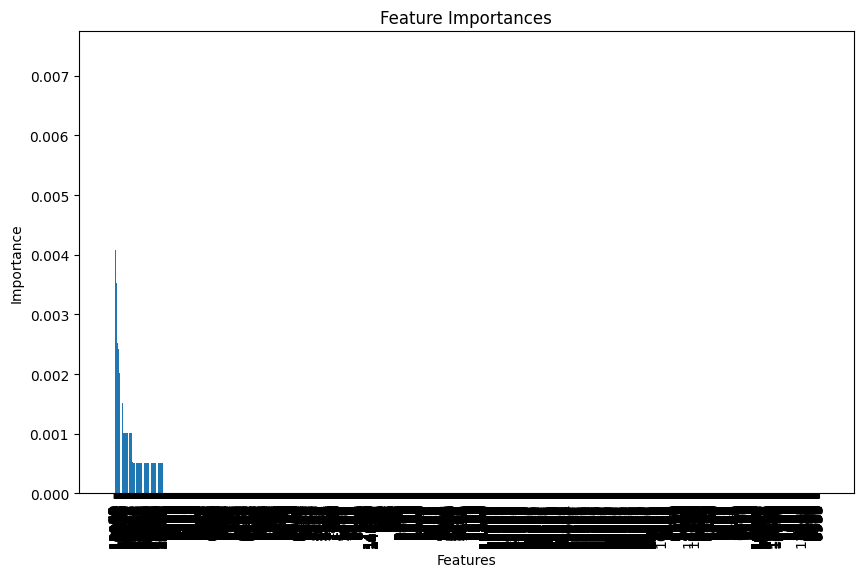

In [49]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Initialize the decision tree classifier
tree_clf = DecisionTreeClassifier()

# Fit the decision tree model to the data
tree_clf.fit(X_processed_cleaned, y_encoded)

# Extract feature importances
feature_importances = tree_clf.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_processed_cleaned .shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X_processed_cleaned .shape[1]), X_processed_cleaned.columns[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_processed_cleaned, y_encoded, test_size=0.2, random_state=42)

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)

# Create the ensemble model using voting
ensemble_model = VotingClassifier(estimators=[('rf', rf_classifier), ('gb', gb_classifier)], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model
ensemble_predictions = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Model Report:")
print(classification_report(y_test, ensemble_predictions))

Ensemble Model Accuracy: 0.08312342569269521
Ensemble Model Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         0
          26       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         1
          33 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [ ]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Initialize target encoder with the updated categorical columns
target_encoder = ce.TargetEncoder(cols=categorical_cols_encoded)

# Fit and transform target encoder on the training data
X_train_encoded = target_encoder.fit_transform(X_train, y_train)

# Transform the testing data using the same target encoding mapping
X_test_encoded = target_encoder.transform(X_test)

In [38]:
from sklearn.ensemble import RandomForestClassifier

X_train_encoded.columns = X_train_encoded.columns.astype(str)
X_test_encoded.columns = X_test_encoded.columns.astype(str)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model to the training data
rf_classifier.fit(X_train_encoded, y_train)

# Predictions on the testing data
y_pred = rf_classifier.predict(X_test_encoded)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.11838790931989925
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         1
          36       0.00      0.00      0.00         0
          38       0.00      0.00      0.00         0
          39       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          43       0.00     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [47]:
import xgboost as xgb

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_cleaned, y_encoded, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor()

# Fit the model
xgb_model.fit(X_train, y_train)

# Get feature importance
importance = xgb_model.feature_importances_

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top features
selected_features = feature_importance_df.head(10)['Feature'].tolist()

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import classification_report
import numpy as np

n_iterations = 20
threshold_accuracy = 0.85  # Set the desired threshold accuracy value

for i in range(n_iterations):
    print(f"Iteration {i+1}/{n_iterations}")

    # Step 1: Train a gradient boosting model for feature selection
    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_processed_cleaned, y_encoded)

    # Step 2: Select features based on their importance scores
    feature_importances = gb_model.feature_importances_
    selected_features_gb = X_processed_cleaned.columns[feature_importances > np.median(feature_importances)]
    
    num_classes = len(np.unique(y_encoded))

    # Step 3: Train a neural network using the selected features
    model = Sequential()
    model.add(Dense(64, input_dim=len(selected_features_gb), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))  # Change output layer activation to 'softmax'

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Change loss function

    # Step 4: Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(X_processed_cleaned[selected_features_gb], y_encoded, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Monitor performance
    if max(history.history['val_accuracy']) >= threshold_accuracy:
        print("Desired accuracy threshold reached. Stopping iterations.")
        break

# Make predictions
y_pred = model.predict(X_processed_cleaned[selected_features_gb])
y_pred_binary = np.argmax(y_pred, axis=1)

# Generate a classification report
report = classification_report(y_encoded, y_pred_binary)

print("Classification Report:")
print(report)


Iteration 1/20


In [10]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import make_scorer, accuracy_score

# Define a function to create the Keras model
def create_model(optimizer=Adam(), learning_rate=0.01, momentum=0.9):
    model = Sequential()
    model.add(Dense(64, input_dim=len(selected_features_gb), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with custom optimizer and learning rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer(lr=learning_rate, momentum=momentum), metrics=['accuracy'])
    return model

# Define the grid of hyperparameters to search
param_grid = {
    'optimizer': [Adam, RMSprop, SGD, Adagrad, Adadelta],
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0.9, 0.99]
}

# Create a custom scorer for accuracy
scorer = make_scorer(accuracy_score)

# Initialize the grid search with the custom model and parameters
grid = GridSearchCV(estimator=create_model(), param_grid=param_grid, cv=3, scoring=scorer)

# Perform grid search
grid_result = grid.fit(X_processed_cleaned[selected_features_gb], y_encoded)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'selected_features_rf' is not defined